In [8]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing import image
import keras
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy,Recall
import numpy as np

In [9]:
# Fonction pour redimensionner, normaliser et prétraiter une image pour VGG16
def preprocess_image_efficientB0(img_path, target_size=(224, 224)):
    # Charger l'image depuis le chemin du fichier en couleur
    img = cv2.imread(img_path)
    # Redimensionner l'image à la taille cible pour EfficientNetB0
    img_resized = cv2.resize(img, target_size)
    # Prétraiter l'image pour EfficientNetB0
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed

# Chemin vers les dossiers contenant les images covid et pas covid
pas_covid_path = "../../data/raw/datasets/Covid_PasCovid_750_Dataset_All/PAS_COVID" #0
covid_path = "../../data/raw/datasets/Covid_PasCovid_750_Dataset_All/COVID" # 0
# :{0: 'PAS_COVID', 1: 'COVID'}
# Liste pour stocker les données d'images et les étiquettes
images_data = []
labels = []

# Parcours du dossier contenant les images PAS COVID les labelliser à 0
for filename in os.listdir(pas_covid_path):
    # Construire le chemin complet de l'image
    img_path = os.path.join(pas_covid_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(0)

# Parcours du dossier contenant les images COVID et les labelliser à 0
for filename in os.listdir(covid_path):
    img_path = os.path.join(covid_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(1)

# Conversion des données
images_data = np.array(images_data)
labels = np.array(labels)

# Division des données en ensembles d'entraînement et de validation
x_train, x_val, y_train, y_val = train_test_split(images_data, labels, test_size=0.2, random_state=1234)

# Redivision des données d'entrainement en données d'entrainement et evaluation
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=1234)

batch=int(len(x_train)/10) # Batch size égal a 10% de la taille des données d'entrainements

print(f"batch size {batch}")

batch size 96


In [10]:
from keras import regularizers
from keras.regularizers import l1

# Définition de la fonction de construction de modèle pour Keras Tuner
# Keras Tuner: Learning rate, Couche Dense, Dropout et Droupout connect rate spécifique à EfficientNet, et learning rate pour la régularisation
def build_model(hp):
    # Hyperparamètres à rechercher
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log') # 1
    units = hp.Int('units', min_value=32, max_value=512, step=16) # 1
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05) # 1
    dropout_connect_rate = hp.Float('dropout_connect_rate', min_value=0.0, max_value=0.5, step=0.05) # 1
    l2_lambda = hp.Choice('l2_lambda', values=[1e-3, 1e-4, 1e-5]) # Hyperparamètre pour la régularisation L2
    
    # Chargement du modèle EfficientNetB0 pré-entraîné
    base_model = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=dropout_connect_rate)
    # Dégel de toutes les couches de convolution
    print(f"Nombre de couches base_model {len(base_model.layers)}")
    i=0
    for layer in base_model.layers:
        if isinstance(layer, Conv2D):
            layer.trainable = True  # Garde les couches BatchNormalization gelées pour stabiliser les activations
            i+=1
        else:
            layer.trainable = False  # Maintient les autres types de couches gelées  
    print(f"{i} Couches dégelées") 
    # Ajout des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_lambda))(x)  # Utilisation de la régularisation L2
    
    # Ajouter plusieurs couches Dropout
    for _ in range(hp.Int('num_dropout_layers', min_value=1, max_value=3)):  # Limite le nombre de couches de dropout à 3 pour prévenir la sous-adaptation 3
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x) # Amélioration de la stabilité de l'apprentissage
    output = Dense(1, activation='sigmoid')(x)

    # Création du modèle final
    model = Model(inputs=base_model.input, outputs=output)

    # Compilation du modèle avec les hyperparamètres
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
# Early Stopping basé sur la métrique de val accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,  
    restore_best_weights=True,  
    mode='max'  
)

# Configuration du tuner d'hyperparamètres RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Objectif d'optimiser la précision de validation
    max_trials=5,  
    executions_per_trial=1, 
    directory='EfficientNetB0_CV_750_VA_Filentuned',
    project_name='EfficientNetB0_CV_750_VA_Filentuned_PJ'
)

tuner.search(x_train, y_train, epochs=100, batch_size=batch, validation_data=(x_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 09m 17s]
val_accuracy: 0.9399999976158142

Best val_accuracy So Far: 0.9766666889190674
Total elapsed time: 00h 58m 47s


In [ ]:
'''
RUN BASE SUR VAL_ACCURACY
Trial 4 Complete [00h 07m 13s]
val_accuracy: 0.5266666412353516

Best val_accuracy So Far: 0.9766666889190674
Total elapsed time: 00h 49m 30s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.00095037        |0.00035772        |learning_rate
288               |384               |units
0.1               |0.05              |dropout_rate
0.25              |0.4               |dropout_connect_rate
1e-05             |0.0001            |l2_lambda
2                 |2                 |num_dropout_layers

Trial 5 Complete [00h 09m 17s]
val_accuracy: 0.9399999976158142

Best val_accuracy So Far: 0.9766666889190674
Total elapsed time: 00h 58m 47s
'''

In [12]:
# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]

# Construire le modèle avec les meilleurs hyperparamètres trouvés
best_model = tuner.hypermodel.build(best_hp)

Nombre de couches base_model 238
65 Couches dégelées


In [13]:
print(best_hp.values)

{'learning_rate': 0.00035771684580498156, 'units': 384, 'dropout_rate': 0.05, 'dropout_connect_rate': 0.4, 'l2_lambda': 0.0001, 'num_dropout_layers': 2}


In [38]:
# {'learning_rate': 0.00035771684580498156, 'units': 384, 'dropout_rate': 0.05, 'dropout_connect_rate': 0.4, 'l2_lambda': 0.0001, 'num_dropout_layers': 2}

In [14]:
import dill as pickle

# Sauvegarder l'objet dans un fichier
with open('EfficientNetB0_CV_750_randomsearch.pkl', 'wb') as file:
    pickle.dump(tuner, file)
#import pickle

# Charger l'objet depuis le fichier
with open('EfficientNetB0_CV_750_randomsearch.pkl', 'rb') as file:
    random_search_loaded = pickle.load(file)


In [15]:
# Entraîner le modèle avec les meilleurs hyperparamètres trouvés
history = best_model.fit(x_train, y_train,
                         epochs=100,batch_size=batch,
                         validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7340 - loss: 0.6035 - val_accuracy: 0.8567 - val_loss: 0.5556
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9131 - loss: 0.2781 - val_accuracy: 0.7467 - val_loss: 0.5107
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9563 - loss: 0.1935 - val_accuracy: 0.9033 - val_loss: 0.3835
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9780 - loss: 0.1237 - val_accuracy: 0.9433 - val_loss: 0.3114
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9712 - loss: 0.1228 - val_accuracy: 0.9467 - val_loss: 0.2722
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9942 - loss: 0.0808 - val_accuracy: 0.8933 - val_loss: 0.3744
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9980 - loss: 0.0793 - val_accuracy: 0.9633 - val_loss: 0.2701
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9908 - loss: 0.0792 - val_accuracy: 0.9467 - v

In [ ]:
## Metriques

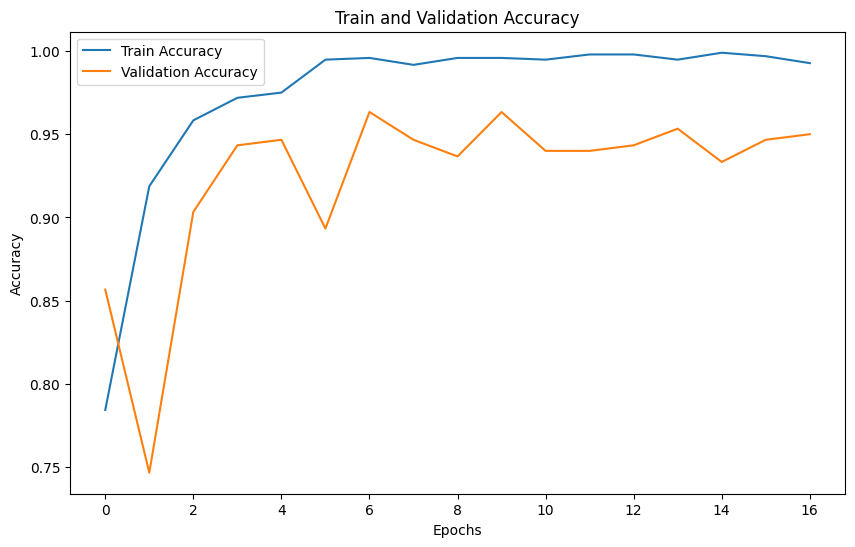

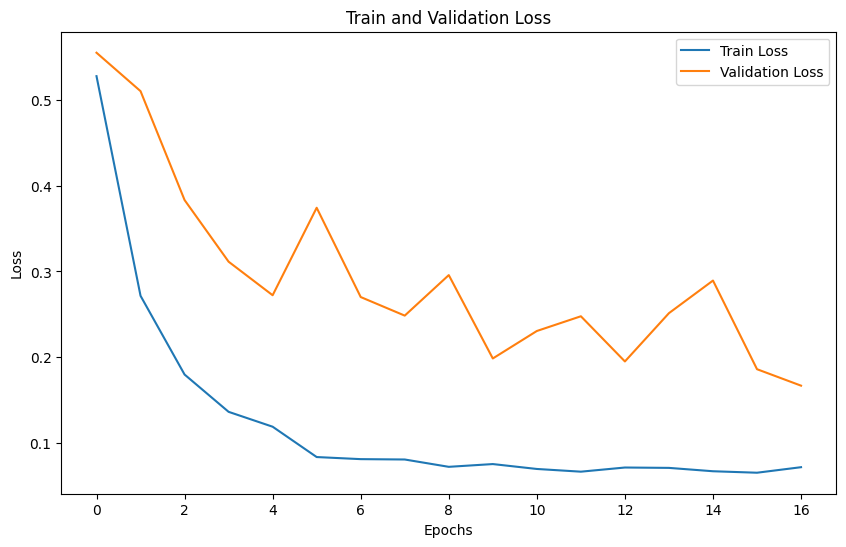

In [29]:
import matplotlib.pyplot as plt

# Afficher et sauvegarder l'accuracy en fonction du nombre d'époques
plt.figure(figsize=(10, 6))  # Optionnel: Définir la taille de l'image
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.savefig('EfficientNetB0_CV_750_history_accuracy.png')  # Sauvegarde de l'image avant plt.show()
plt.show()

# Afficher et sauvegarder la perte en fonction du nombre d'époques
plt.figure(figsize=(10, 6))  # Optionnel: Définir la taille de l'image
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.savefig('EfficientNetB0_CV_750_history_loss.png')  # Sauvegarde de l'image avant plt.show()
plt.show()


In [17]:
import pickle
import json

# Enregistrer le modèle
best_model.save('../../data/processed/models/notebooks/EfficientNetB0_CV_750_model.keras')
best_model.save('../../data/processed/models/notebooks/EfficientNetB0_CV_750_model.h5')

# Enregistrer l'historique
with open('../../data/processed/models/notebooks/EfficientNetB0_CV_750_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Enregistrer les métriques dans un fichier JSON
metrics_dict = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

with open('../../data/processed/models/notebooks/EfficientNetB0_CV_750_metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Faire des prédictions sur l'ensemble de données de test
predictions_val = best_model.predict(x_val)
print(f"predictions val {predictions_val}")
# Convertir les prédictions en classes (si c'est un problème de classification)
#predicted_classes = np.argmax(predictions,axis=1)
predicted_classes_val = (y_val > 0.5).astype(int)
print(f"predicted_classes_val {predicted_classes_val}")
print(f"y_val {y_val}")
#y_val_classes = np.argmax(y_val)
#print(f"y_val_classes {y_val_classes}")
# Calculer l'accuracy
val_accuracy = np.mean(predicted_classes_val == y_val)

print("Val Accuracy:", val_accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step
predictions val [[0.01296251]
 [0.02091725]
 [0.04023895]
 [0.7499066 ]
 [0.02669459]
 [0.9750816 ]
 [0.00542427]
 [0.94512075]
 [0.00995951]
 [0.73281044]
 [0.9898545 ]
 [0.74447596]
 [0.98215646]
 [0.721188  ]
 [0.8781628 ]
 [0.22228879]
 [0.8065905 ]
 [0.01326222]
 [0.98967177]
 [0.7653556 ]
 [0.07111162]
 [0.87027806]
 [0.01282183]
 [0.13168578]
 [0.76793   ]
 [0.867447  ]
 [0.70775604]
 [0.9678477 ]
 [0.664431  ]
 [0.98107177]
 [0.97745097]
 [0.00244959]
 [0.97792184]
 [0.98336697]
 [0.00583197]
 [0.00478118]
 [0.98948693]
 [0.00930738]
 [0.07522488]
 [0.00400044]
 [0.94979024]
 [0.5137428 ]
 [0.85742164]
 [0.00679849]
 [0.7671541 ]
 [0.09724938]
 [0.99188715]
 [0.02095405]
 [0.00176996]
 [0.7717955 ]
 [0.20679484]
 [0.25810343]
 [0.00637845]
 [0.03583636]
 [0.06518699]
 [0.15987149]
 [0.01272591]
 [0.03426512]
 [0.9476236 ]
 [0.04465141]
 [0.0060403 ]
 [0.5169376 ]
 [0.9061676 ]
 [0.00337096]
 [0.00756779]
 [0.98696434]
 [0.9671467 ]
 [0.8

'\nmetrics_dict={}\n    y_eval_pred = model.predict(X_eval)\n    print(\'----------bin_get_prediction_metrics(model,X_eval,y_eval)-------\')\n    print(f"Y EVAL {y_eval}")\n    print(f"Y EVAL PRED {y_eval_pred}")\n    \n    y_eval_pred = (y_eval > 0.5).astype(int)\n    print(f"Y EVAL PRED Binary {y_eval_pred}")\n    \n    average="binary"\n    # Calcul de la perte\n    bce = BinaryCrossentropy()\n    loss = bce(y_eval, y_eval_pred).numpy()\n\n    # Calculer la précision\n    accuracy_s = accuracy_score(y_eval, y_eval_pred)\n    print("Precision/accuracy :", accuracy_s)\n    # Affichage de la perte\n    print("Perte (BinaryCrossentropy) :", loss)\n    \n    # Calculer le recall\n    recall = recall_score(y_eval, y_eval_pred,average=average)\n    print("Recall :",recall)\n       \n    # Calculer le F1-score\n    f1 = f1_score(y_eval, y_eval_pred,average=average)\n    print("F1-Score :",f1)  \n'

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Faire des prédictions sur l'ensemble de données de test
predictions_eval = best_model.predict(x_eval)
print(f"predictions_eval {predictions_eval}")
# Convertir les prédictions en classes (si c'est un problème de classification)
#predicted_classes = np.argmax(predictions,axis=1)
predicted_classes_eval = (y_eval > 0.5).astype(int)
print(f"predicted_classes_eval {predicted_classes_eval}")
print(f"y_eval {y_eval}")
#y_val_classes = np.argmax(y_val)
#print(f"y_val_classes {y_val_classes}")
# Calculer l'accuracy
eval_accuracy = np.mean(predicted_classes_eval == y_eval)

print("EVAL Accuracy:", eval_accuracy)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step
predictions_eval [[3.65357148e-03]
 [9.38151300e-01]
 [1.39047466e-02]
 [6.53816938e-01]
 [8.89705539e-01]
 [2.44907420e-02]
 [9.90334272e-01]
 [2.64430977e-02]
 [9.93658125e-01]
 [7.37202406e-01]
 [1.71657093e-02]
 [7.49388516e-01]
 [9.41125929e-01]
 [9.76162195e-01]
 [9.12952662e-01]
 [1.74462497e-01]
 [3.36258560e-01]
 [6.80325925e-02]
 [9.16028082e-01]
 [9.61835027e-01]
 [9.51950252e-01]
 [1.41493194e-02]
 [1.51239447e-02]
 [7.37161994e-01]
 [7.47991726e-02]
 [1.01582222e-01]
 [6.65294170e-01]
 [6.84676409e-01]
 [7.58857001e-03]
 [9.26000237e-01]
 [5.77299833e-01]
 [1.18632447e-02]
 [1.19815990e-02]
 [8.53060246e-01]
 [7.04171658e-01]
 [7.15914428e-01]
 [9.70073402e-01]
 [1.14774086e-01]
 [6.69352617e-03]
 [9.44799542e-01]
 [1.35974062e-03]
 [9.45673645e-01]
 [5.54660428e-03]
 [8.68564546e-01]
 [6.67444229e-01]
 [6.68978572e-01]
 [2.30670318e-01]
 [1.19266147e-02]
 [1.89311039e-02]
 [1.01265581e-02]
 [3.52643698e-01]
 [8.52291465e-01]
 [3.2330

'\nmetrics_dict={}\n    y_eval_pred = model.predict(X_eval)\n    print(\'----------bin_get_prediction_metrics(model,X_eval,y_eval)-------\')\n    print(f"Y EVAL {y_eval}")\n    print(f"Y EVAL PRED {y_eval_pred}")\n    \n    y_eval_pred = (y_eval > 0.5).astype(int)\n    print(f"Y EVAL PRED Binary {y_eval_pred}")\n    \n    average="binary"\n    # Calcul de la perte\n    bce = BinaryCrossentropy()\n    loss = bce(y_eval, y_eval_pred).numpy()\n\n    # Calculer la précision\n    accuracy_s = accuracy_score(y_eval, y_eval_pred)\n    print("Precision/accuracy :", accuracy_s)\n    # Affichage de la perte\n    print("Perte (BinaryCrossentropy) :", loss)\n    \n    # Calculer le recall\n    recall = recall_score(y_eval, y_eval_pred,average=average)\n    print("Recall :",recall)\n       \n    # Calculer le F1-score\n    f1 = f1_score(y_eval, y_eval_pred,average=average)\n    print("F1-Score :",f1)  \n'

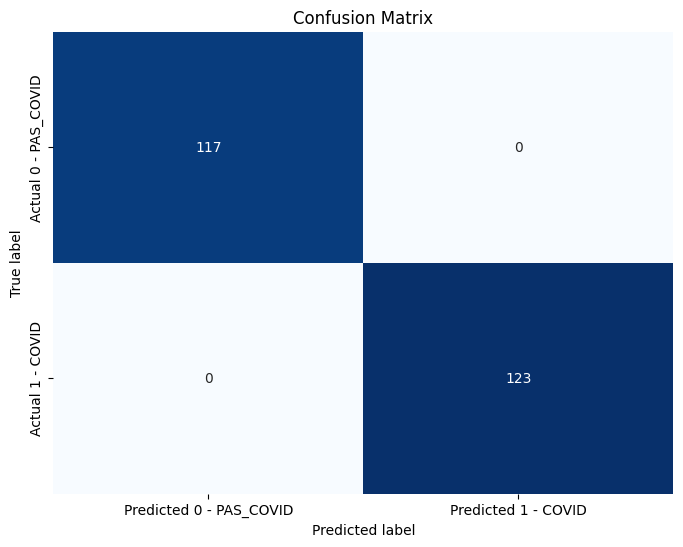

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_eval, predicted_classes_eval)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0 - PAS_COVID', 'Predicted 1 - COVID'],
            yticklabels=['Actual 0 - PAS_COVID', 'Actual 1 - COVID'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Sauvegarder l'image de la matrice de confusion
plt.savefig('EfficientNetB0_CV_750_confusion_matrix.png')  # Sauvegarde de l'image avant plt.show()

plt.show()

GRAD-CAM

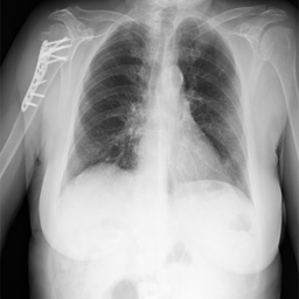

In [69]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
#preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "top_conv"

# The local path to our target image
img_path =('./test_images/COVID-231.png')
#{0: 'Viral_Pneumonia', 1: 'Lung_Opacity', 2: 'Normal', 3: 'COVID'}
display(Image(img_path))

In [63]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

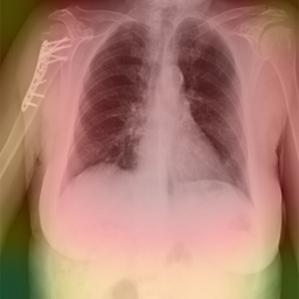

In [56]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)